<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_generalized_copy_highnoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the latest implementation
This includes;
1. agg
2. clasical and quantum communication
3. teleportaion options

flowchart LR
  %% ----------- Inputs / Config -----------
  A[Start Round t\nConfig:\n• use_deep_unfolding (DU)\n• aggregation ∈ {best, fedavg}\n• uplink_mode ∈ {classical_full, seeded_sparse, quantum}\n• downlink_mode ∈ {classical_full, seeded, quantum}\n• gamma (warm-start)\n• teleport noise, shots]:::cfg

  %% ----------- Broadcast -----------
  A --> B[Server has Global Params w^{t}\n(also prev_broadcast_params = w^{t})]
  B --> C{Downlink mode?}

  C -->|classical_full| C1[[Broadcast full w^{t}]]
  C -->|seeded (seeded mask + scale)| C2[[Send seed & mask\nClients reconstruct ŵ^{t}]]
  C -->|quantum (teleportation)| C3[[Teleport w^{t}\n(θ → θ′ via Bell pair)\nRecord fidelity, β shrink]]

  C1 --> D
  C2 --> D
  C3 --> D

  %% ----------- Local Training -----------
  subgraph S[Each Client i]
    direction TB
    D[Client i receives parameters\nw_i^{t,0} ← w^{t} (reconstructed if seeded/quantum)] --> E[Warm-start LR,PERT:\nLR_i^0 = (1-γ)LR_init + γLR_i^{t-1}\nPERT_i^0 = (1-γ)PERT_init + γPERT_i^{t-1}]
    E --> F{use_deep_unfolding?}
    F -->|Yes| G[Repeat k steps:\nfit → meta-update {LR,PERT}\nclip to trust region\nset w_i^{t,k}]
    F -->|No| H[Single fit with fixed LR, PERT\nset w_i^{t,1}]
    G --> I[Compute metrics (train/test acc,\nclient size, objective)]
    H --> I
    I --> J{Uplink mode?}
    J -->|classical_full| J1[[Send full weights w_i^{t,*}]]
    J -->|seeded_sparse| J2[[Send seeded sparse Δ_i\n(quantized top-k wrt anchor)]]
    J -->|quantum| J3[[Teleport Δ_i or w_i^{t,*}\n(log fidelity)]]
  end

  %% ----------- Aggregation -----------
  J1 --> K
  J2 --> K
  J3 --> K

  K{Aggregation?} -->|best\n(validation-gated τ-mix)| K1[[Pick client j = argmin L_val\nIf improve ≥ ε: w^{t+1} ← (1-τ)w^{t} + τ w_j]]
  K -->|fedavg| K2[[Size-weighted average\nw^{t+1} ← Σ (n_i/N) w_i^{t,*}]]

  K1 --> L[Log round metrics:\nacc_global, L_val,\nbytes_up/down, latency,\nfidelity stats, β]
  K2 --> L
  L --> M[Proceed to Round t+1]
  
  classDef cfg fill:#f5f7ff,stroke:#6b7cff,color:#222,stroke-width:1.2px;


In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/"

In [4]:

#from configs.dataset_genome_noniid.py import *     # swap to other configs as needed

In [5]:
from common.imports import *
from configs.dataset_genome import *     # swap to other configs as needed
from io_utils.naming import stamp_now, build_param_str, make_filenames

# main.py or notebook cell
from configs.base_config import *
from io_utils.naming import build_param_str, stamp_now, make_filenames


stamp, date_str = stamp_now()

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root=drive_root,
    dataset_name=dataset_name,
    split_type=split_type,
    date_str=date_str,
    aggregation=aggregation,
    select_upload=select_upload,
    use_deep_unfolding=use_deep_unfolding,
    gamma=gamma,
    uplink_mode=uplink_mode,
    downlink_mode=downlink_mode,
    up_k_ratio=up_k_ratio,
    up_bits=up_bits,
    down_mask_ratio=down_mask_ratio,
    down_scale=down_scale,
    noise_preset=noise_preset,
    shots_used=shots_used,

)
print(best_client_csv_file)
print(global_csv_file)
print(local_csv_file)
print(validation_csv_file)

from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Qiskit: 1.4.5
qiskit_aer available?: True
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/highnoise/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-quantum_Q-on_high_shots256_21_10_2025_Best_Client.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/highnoise/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-quantum_Q-on_high_shots256_21_10_2025_Global.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/Results/quantumCommunication/genome/highnoise/tDuQFL_Genome_NONIID_AGG-best_SU-all_DU-on_g0p5_UL-quantum__DL-quantum_Q-on_high_shots256_21_10_2025_Local

Load and Split data

In [6]:
# ============================
# noniid_viz.py  (drop-in)
# ============================
from typing import List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

# ----- helpers to read labels from your Client structure -----
def _gather_labels_per_client(
    clients: List, epoch: Optional[int] = 0
) -> List[np.ndarray]:
    """
    Extract label arrays per client.
    If epoch is None, aggregate labels across all epochs.
    """
    labels_per_client = []
    for cl in clients:
        if epoch is None:
            # concat labels across all epochs
            labs = []
            for ep in cl.data:
                labs.extend([int(item["label"]) for item in ep])
            labels_per_client.append(np.array(labs, dtype=int))
        else:
            labs = [int(item["label"]) for item in clients[clients.index(cl)].data[epoch]]
            labels_per_client.append(np.array(labs, dtype=int))
    return labels_per_client

def _counts_and_props(
    labels_per_client: List[np.ndarray],
    class_names: Optional[List[str]] = None
) -> Tuple[np.ndarray, np.ndarray, List[int], List[str]]:
    """
    Build class×client counts and proportions.
    Returns (counts[C,M], props[C,M], classes, class_names_resolved)
    """
    # discover classes present
    classes = sorted(set(int(y) for arr in labels_per_client for y in np.unique(arr)))
    C, M = len(classes), len(labels_per_client)
    counts = np.zeros((C, M), dtype=int)
    for m, arr in enumerate(labels_per_client):
        for ci, c in enumerate(classes):
            counts[ci, m] = np.sum(arr == c)
    colsum = counts.sum(axis=0, keepdims=True).astype(float)
    props = np.divide(counts, np.where(colsum == 0, 1.0, colsum), where=colsum != 0)
    if class_names is None:
        class_names = [str(c) for c in classes]
    return counts, props, classes, class_names

# ----- main public function -----
def plot_noniid_distribution(
    clients: List,
    *,
    epoch: Optional[int] = 0,          # set None to aggregate across all epochs
    class_names: Optional[List[str]] = None,
    save_prefix: Optional[str] = None  # e.g., "genome_noniid"
):
    """
    Visualize label skew across clients for a given epoch (or all epochs).
    Produces:
      (A) class×client heatmap of counts
      (B) stacked bars of per-client class proportions
      (C) per-client sample counts
    """
    labels_per_client = _gather_labels_per_client(clients, epoch=epoch)
    counts, props, classes, names = _counts_and_props(labels_per_client, class_names)

    C, M = counts.shape
    x = np.arange(M)



    # (B) Stacked bar: per-client class proportions
    plt.figure(figsize=(5,4))
    plt.rcParams.update({"font.size": 18})
    bottom = np.zeros(M)
    for c in range(C):
        plt.bar(x, props[c, :], bottom=bottom, label=f"class {names[c]}")
        bottom += props[c, :]
    plt.xticks(x, [f"C{m}" for m in x])
    plt.ylim(0, 1)
    plt.ylabel("Proportion")
    plt.xlabel("Client")
    #plt.title(f"Per-client class proportions ({title_epoch})")
    plt.legend(fontsize=16,ncol=2,columnspacing=0.7,handletextpad=0.4,frameon=True, handlelength=1.0)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_proportions_stacked.pdf", dpi=300)
    plt.show()

    # (C) Per-client sample counts
    sample_counts = counts.sum(axis=0)
    ymax = sample_counts.max()
    plt.rcParams.update({"font.size": 16})
    plt.figure(figsize=(5,4))
    plt.bar(x, sample_counts)
    # Add headroom so tallest bar (and its label) won't clip
    plt.ylim(0, ymax * 1.15)                 # 15% headroom
    for m, val in enumerate(sample_counts):
      plt.text(m, val + 0.02 * ymax, str(int(val)),
             ha='center', va='bottom', fontsize=16)
    plt.xticks(x, [f"C{m}" for m in x])
    plt.ylabel("# samples")

    plt.xlabel("Client")
    #plt.title(f"Client sample counts ({title_epoch})")
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_sample_counts.pdf", dpi=300)
    plt.show()


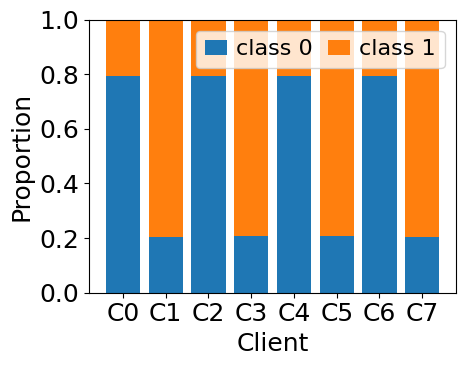

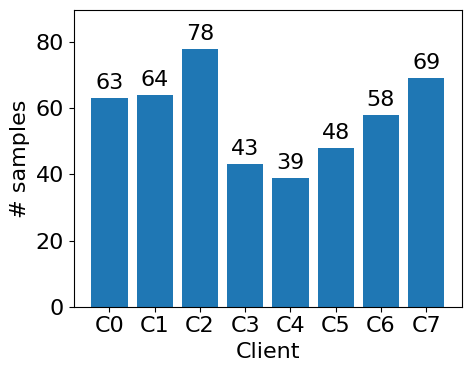

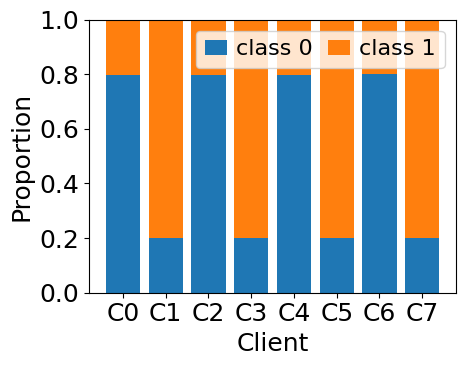

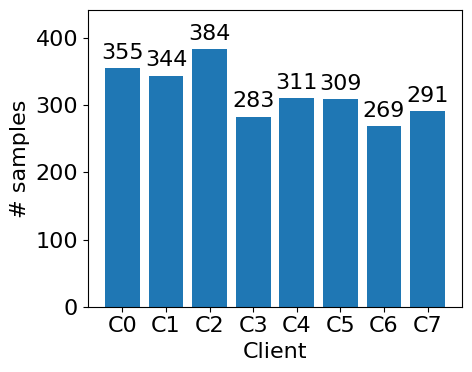

In [7]:
from training.data_factory import build_clients_and_meta
# After you call build_clients_and_meta(...)
clients, Xtest, ytest, num_features = build_clients_and_meta(
    dataset_name="GENOME",
    split_type="NONIID",
    num_clients=8,
    num_epochs=5,
    samples_per_epoch=64,
    word_size=40,
    global_seed=42,
    non_iid_ratio=0.8,
    quantity_variation=0.5,
    noniid_seed=42,
)

# Import and plot
#from noniid_viz import plot_noniid_distribution

# Visualize one epoch (e.g., first epoch)
plot_noniid_distribution(clients, epoch=0, save_prefix="genome_noniid_ep0")

# Or aggregate across ALL epochs
plot_noniid_distribution(clients, epoch=None, save_prefix="genome_noniid_all")


run federated loop and plot

In [8]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

# examples/run_switch.py
from configs.base_config import *
from training.data_factory import build_clients_and_meta
from training.loop import run_federated_training
from training.metrics import metrics_init
import os, numpy as np

param_str = build_param_str(
    num_clients,
    num_federated_layers,
    num_deep_unfolding_iterations,
    initial_learning_rate,
    initial_perturbation,
)


# 1) Build clients + meta from config
clients, test_sequences, test_labels, num_features = build_clients_and_meta(
    dataset_name=dataset_name,
    split_type=split_type,
    num_clients=num_clients,
    num_epochs=num_epochs,
    samples_per_epoch=samples_per_epoch,
    word_size=word_size,
    global_seed=global_seed,
    mnist_n_features=mnist_n_features,
    mnist_digit_a=mnist_digit_a,
    mnist_digit_b=mnist_digit_b,
    breast_pca_n_features=breast_pca_n_features,
    non_iid_ratio=non_iid_ratio,
    quantity_variation=quantity_variation,
    noniid_seed=noniid_seed,
)

# 2) Validation set (use test as val if you don’t have a separate split)
X_val, y_val = test_sequences, test_labels

# 3) Outputs
os.makedirs(drive_root, exist_ok=True)


metrics = metrics_init(log_path=os.path.join(drive_root, "round_metrics.csv"))

# 4) Train
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences, test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    metrics=metrics,
    aggregation=aggregation,                  # "best" or "fedavg"
    select_upload=select_upload,              # "all" or "winner_only" (used for best)
    use_deep_unfolding=use_deep_unfolding,    # True/False
    uplink_mode=uplink_mode,                  # "classical_full" | "seeded_sparse" | "quantum"
    downlink_mode=downlink_mode,              # "classical_full" | "seeded" | "quantum"
    down_seed_base=down_seed_base,
    down_scale=down_scale,
    down_mask_ratio=down_mask_ratio,
    up_bits=up_bits,
    up_k_ratio=up_k_ratio,
    use_teleportation_backend=True,
    noise_preset=noise_preset,
    shots_used=shots_used,
    client_hparams_csv_file=os.path.join(drive_root, f"hparams_{dataset_name}_{split_type}_{param_str}.csv"),
)

print("Global accuracy per round:", global_acc)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.508882 step=0.009796 g_raw=+0.008 g_sm=+0.002 acc=1 | LR→0.140280 PERT→0.140000 (scale=0.04)
[meta] cb#010 loss=0.482469 step=0.2272 g_raw=+0.083 g_sm=+0.010 acc=1 | LR→0.140561 PERT→0.140000 (scale=0.04)
[meta] cb#015 loss=0.473572 step=0.07624 g_raw=+0.025 g_sm=+0.013 acc=1 | LR→0.140843 PERT→0.140001 (scale=0.04)
[meta] cb#020 loss=0.463014 step=0.1185 g_raw=+0.046 g_sm=+0.016 acc=1 | LR→0.141125 PERT→0.140001 (scale=0.04)
[meta] cb#025 loss=0.456819 step=0.07734 g_raw=+0.030 g_sm=+0.017 acc=1 | LR→0.141408 PERT→0.140001 (scale=0.04)
[client 0 | unfold 1] LR 0.140000->0.141408, PERT 0.140000->0.140001 | g_raw_mean=+0.023, g_sm_mean=+0.010
[meta] cb#030 loss=0.434573 step=0.03391 g_raw=+0.015 g_sm=+0.021 acc=1 | LR→0.141692 PERT→0.140002 (scale=0.04)
[meta] cb#035 loss=0.422966 step=0.1132 g_raw=+0.039 g_sm=+0.022 acc=1 | LR→0.141976 PERT→0.140002 (scale=0.04)
[meta] cb#040 loss=0.410890 step=0.12 g_raw=+0.04

Training Progress:  10%|█         | 1/10 [22:26<3:21:59, 1346.63s/it]

[Round   0] acc_g=0.566 (μ=0.514, σ=0.026, FG=0.047) | t=1277.340s, val=0.723 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 0] ↓=5B ↑=25B | (Σ↓=5B, Σ↑=25B)
[Round 1] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.538819 step=0.1271 g_raw=+0.056 g_sm=+0.007 acc=1 | LR→0.143883 PERT→0.140006 (scale=0.04)
[meta] cb#010 loss=0.498530 step=0.2583 g_raw=+0.096 g_sm=+0.017 acc=1 | LR→0.144171 PERT→0.140007 (scale=0.04)
[meta] cb#015 loss=0.439230 step=0.06753 g_raw=+0.023 g_sm=+0.026 acc=1 | LR→0.144461 PERT→0.140007 (scale=0.04)
[meta] cb#020 loss=0.413996 step=0.1004 g_raw=+0.032 g_sm=+0.028 acc=1 | LR→0.144751 PERT→0.140008 (scale=0.04)
[meta] cb#025 loss=0.400034 step=0.0001461 g_raw=-0.002 g_sm=+0.027 acc=1 | LR→0.145041 PERT→0.140009 (scale=0.04)
[client 0 | unfold 1] LR 0.143596->0.145041, PERT 0.140006->0.140009 | g_raw_mean=+0.039, g_sm_mean=+0.019
[meta] cb#

Training Progress:  20%|██        | 2/10 [43:21<2:52:21, 1292.65s/it]

[Round   1] acc_g=0.532 (μ=0.523, σ=0.046, FG=0.078) | t=1183.628s, val=0.686 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 1] ↓=5B ↑=25B | (Σ↓=10B, Σ↑=50B)
[Round 2] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.517069 step=0.039 g_raw=+0.012 g_sm=+0.007 acc=1 | LR→0.145777 PERT→0.140010 (scale=0.04)
[meta] cb#010 loss=0.500368 step=0.08554 g_raw=+0.037 g_sm=+0.014 acc=1 | LR→0.146069 PERT→0.140010 (scale=0.04)
[meta] cb#015 loss=0.490556 step=0.1153 g_raw=+0.041 g_sm=+0.016 acc=1 | LR→0.146362 PERT→0.140010 (scale=0.04)
[meta] cb#020 loss=0.474203 step=0.06322 g_raw=+0.023 g_sm=+0.020 acc=1 | LR→0.146656 PERT→0.140011 (scale=0.04)
[meta] cb#025 loss=0.460950 step=0.06719 g_raw=+0.022 g_sm=+0.022 acc=1 | LR→0.146950 PERT→0.140011 (scale=0.04)
[client 0 | unfold 1] LR 0.145486->0.146950, PERT 0.140009->0.140011 | g_raw_mean=+0.031, g_sm_mean=+0.014
[meta] cb#0

Training Progress:  30%|███       | 3/10 [1:06:19<2:35:22, 1331.85s/it]

[Round   2] acc_g=0.601 (μ=0.538, σ=0.072, FG=0.113) | t=1302.423s, val=0.651 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 2] ↓=5B ↑=25B | (Σ↓=15B, Σ↑=75B)
[Round 3] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.424159 step=0.2464 g_raw=+0.081 g_sm=+0.012 acc=1 | LR→0.146773 PERT→0.140012 (scale=0.04)
[meta] cb#010 loss=0.396809 step=0.1451 g_raw=+0.047 g_sm=+0.018 acc=1 | LR→0.147068 PERT→0.140012 (scale=0.04)
[meta] cb#015 loss=0.370002 step=0.1054 g_raw=+0.037 g_sm=+0.022 acc=1 | LR→0.147363 PERT→0.140013 (scale=0.04)
[meta] cb#020 loss=0.355165 step=0.0952 g_raw=+0.027 g_sm=+0.023 acc=1 | LR→0.147658 PERT→0.140013 (scale=0.04)
[meta] cb#025 loss=0.347291 step=0.07258 g_raw=+0.024 g_sm=+0.022 acc=1 | LR→0.147955 PERT→0.140014 (scale=0.04)
[client 0 | unfold 1] LR 0.146480->0.147955, PERT 0.140012->0.140014 | g_raw_mean=+0.034, g_sm_mean=+0.017
[meta] cb#03

Training Progress:  40%|████      | 4/10 [1:29:45<2:16:04, 1360.83s/it]

[Round   3] acc_g=0.596 (μ=0.506, σ=0.009, FG=0.019) | t=1331.686s, val=0.653 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 3] ↓=5B ↑=25B | (Σ↓=20B, Σ↑=100B)
[Round 4] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.487308 step=0.1368 g_raw=+0.052 g_sm=+0.011 acc=1 | LR→0.147294 PERT→0.140010 (scale=0.04)
[meta] cb#010 loss=0.463605 step=0.07389 g_raw=+0.026 g_sm=+0.016 acc=1 | LR→0.147590 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.435146 step=0.1361 g_raw=+0.046 g_sm=+0.022 acc=1 | LR→0.147886 PERT→0.140011 (scale=0.04)
[meta] cb#020 loss=0.425388 step=0.06608 g_raw=+0.024 g_sm=+0.023 acc=1 | LR→0.148183 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.413771 step=0.03986 g_raw=+0.016 g_sm=+0.023 acc=1 | LR→0.148480 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR 0.147000->0.148480, PERT 0.140010->0.140013 | g_raw_mean=+0.035, g_sm_mean=+0.017
[meta] cb

Training Progress:  50%|█████     | 5/10 [1:51:09<1:51:06, 1333.29s/it]

[Round   4] acc_g=0.652 (μ=0.549, σ=0.081, FG=0.140) | t=1217.636s, val=0.668 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 4] ↓=5B ↑=25B | (Σ↓=25B, Σ↑=125B)
[Round 5] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.450748 step=0.1867 g_raw=+0.070 g_sm=+0.013 acc=1 | LR→0.147570 PERT→0.140012 (scale=0.04)
[meta] cb#010 loss=0.404654 step=0.03104 g_raw=+0.011 g_sm=+0.019 acc=1 | LR→0.147866 PERT→0.140012 (scale=0.04)
[meta] cb#015 loss=0.390203 step=0.09566 g_raw=+0.032 g_sm=+0.021 acc=1 | LR→0.148163 PERT→0.140013 (scale=0.04)
[meta] cb#020 loss=0.347689 step=0.1397 g_raw=+0.042 g_sm=+0.027 acc=1 | LR→0.148460 PERT→0.140013 (scale=0.04)
[meta] cb#025 loss=0.330133 step=0.1119 g_raw=+0.037 g_sm=+0.028 acc=1 | LR→0.148758 PERT→0.140014 (scale=0.04)
[client 0 | unfold 1] LR 0.147275->0.148758, PERT 0.140011->0.140014 | g_raw_mean=+0.040, g_sm_mean=+0.019
[meta] cb#

Training Progress:  60%|██████    | 6/10 [2:07:40<1:21:07, 1216.87s/it]

[Round   5] acc_g=0.719 (μ=0.516, σ=0.032, FG=0.055) | t=927.134s, val=0.669 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 5] ↓=5B ↑=25B | (Σ↓=30B, Σ↑=150B)
[Round 6] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.483830 step=0.1554 g_raw=+0.056 g_sm=+0.005 acc=1 | LR→0.147714 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.482204 step=0.03778 g_raw=+0.010 g_sm=+0.006 acc=1 | LR→0.148010 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.470309 step=0.06963 g_raw=+0.026 g_sm=+0.011 acc=1 | LR→0.148306 PERT→0.140011 (scale=0.04)
[meta] cb#020 loss=0.446293 step=0.1046 g_raw=+0.038 g_sm=+0.016 acc=1 | LR→0.148604 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.423828 step=0.0518 g_raw=+0.020 g_sm=+0.020 acc=1 | LR→0.148902 PERT→0.140012 (scale=0.04)
[client 0 | unfold 1] LR 0.147419->0.148902, PERT 0.140011->0.140012 | g_raw_mean=+0.024, g_sm_mean=+0.009
[meta] cb#0

Training Progress:  70%|███████   | 7/10 [2:28:44<1:01:36, 1232.23s/it]

[Round   6] acc_g=0.693 (μ=0.500, σ=0.006, FG=0.012) | t=1189.542s, val=0.666 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 6] ↓=5B ↑=25B | (Σ↓=35B, Σ↑=175B)
[Round 7] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.414086 step=0.1405 g_raw=+0.048 g_sm=+0.008 acc=1 | LR→0.147790 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.407383 step=0.0186 g_raw=+0.006 g_sm=+0.011 acc=1 | LR→0.148086 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.403093 step=0.07327 g_raw=+0.033 g_sm=+0.011 acc=1 | LR→0.148383 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.397885 step=0.02353 g_raw=+0.008 g_sm=+0.013 acc=1 | LR→0.148680 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.355935 step=0.09739 g_raw=+0.034 g_sm=+0.021 acc=1 | LR→0.148979 PERT→0.140012 (scale=0.04)
[client 0 | unfold 1] LR 0.147495->0.148979, PERT 0.140011->0.140012 | g_raw_mean=+0.027, g_sm_mean=+0.011
[meta] cb

Training Progress:  80%|████████  | 8/10 [2:47:46<40:06, 1203.49s/it]  

[Round   7] acc_g=0.624 (μ=0.506, σ=0.002, FG=0.003) | t=1075.247s, val=0.678 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 7] ↓=5B ↑=25B | (Σ↓=40B, Σ↑=200B)
[Round 8] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.475690 step=0.1271 g_raw=+0.046 g_sm=+0.005 acc=1 | LR→0.147829 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.464458 step=0.04183 g_raw=+0.019 g_sm=+0.010 acc=1 | LR→0.148126 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.441763 step=0.1363 g_raw=+0.049 g_sm=+0.016 acc=1 | LR→0.148423 PERT→0.140011 (scale=0.04)
[meta] cb#020 loss=0.432488 step=0.03717 g_raw=+0.020 g_sm=+0.017 acc=1 | LR→0.148720 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.415542 step=0.07991 g_raw=+0.029 g_sm=+0.020 acc=1 | LR→0.149019 PERT→0.140012 (scale=0.04)
[client 0 | unfold 1] LR 0.147534->0.149019, PERT 0.140010->0.140012 | g_raw_mean=+0.027, g_sm_mean=+0.012
[meta] cb

Training Progress:  90%|█████████ | 9/10 [3:07:05<19:49, 1189.68s/it]

[Round   8] acc_g=0.636 (μ=0.500, σ=0.004, FG=0.010) | t=1090.614s, val=0.669 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 8] ↓=5B ↑=25B | (Σ↓=45B, Σ↑=225B)
[Round 9] Agg=best | Uplink=quantum | Downlink=quantum
[meta] cb#005 loss=0.482068 step=0.01581 g_raw=+0.006 g_sm=+0.004 acc=1 | LR→0.147851 PERT→0.140011 (scale=0.04)
[meta] cb#010 loss=0.456253 step=0.01629 g_raw=+0.007 g_sm=+0.012 acc=1 | LR→0.148147 PERT→0.140011 (scale=0.04)
[meta] cb#015 loss=0.430663 step=0.2232 g_raw=+0.084 g_sm=+0.017 acc=1 | LR→0.148444 PERT→0.140012 (scale=0.04)
[meta] cb#020 loss=0.396383 step=0.1596 g_raw=+0.051 g_sm=+0.023 acc=1 | LR→0.148742 PERT→0.140012 (scale=0.04)
[meta] cb#025 loss=0.385977 step=0.03604 g_raw=+0.014 g_sm=+0.022 acc=1 | LR→0.149040 PERT→0.140013 (scale=0.04)
[client 0 | unfold 1] LR 0.147555->0.149040, PERT 0.140011->0.140013 | g_raw_mean=+0.031, g_sm_mean=+0.014
[meta] cb

Training Progress: 100%|██████████| 10/10 [3:23:20<00:00, 1220.04s/it]

[Round   9] acc_g=0.742 (μ=0.505, σ=0.005, FG=0.010) | t=908.294s, val=0.624 | TEL β=NA, Fid μ=NA, σ=NA, p50=NA, p90=NA | Lat μ=NA, σ=NA, p90=NA | Inst μ=NA, σ=NA | Δ per-dim=NA, ||Δ||₂=NA, max|Δ|=NA | noise=high, shots=256
[Round 9] ↓=5B ↑=25B | (Σ↓=50B, Σ↑=250B)
Global accuracy per round: [0.566, 0.532, 0.601, 0.596, 0.652, 0.719, 0.693, 0.624, 0.636, 0.742]
